# SMS Spam Detection

## Importing Dependincies & Loading The Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("spam.csv", encoding="ISO-8859-1", usecols=["v1", "v2"]) # ISO-8859-1 to handle utf-8 problem. Do not read empty columns
data.columns = ("class", "sms")
data.head()

,class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data.shape

(5572, 2)

In [4]:
data.info() # Both columns are objects, det dummies for labels. Label Encoder will be used for that.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## Data Explorations

Text(0, 0.5, 'Number of Data points')

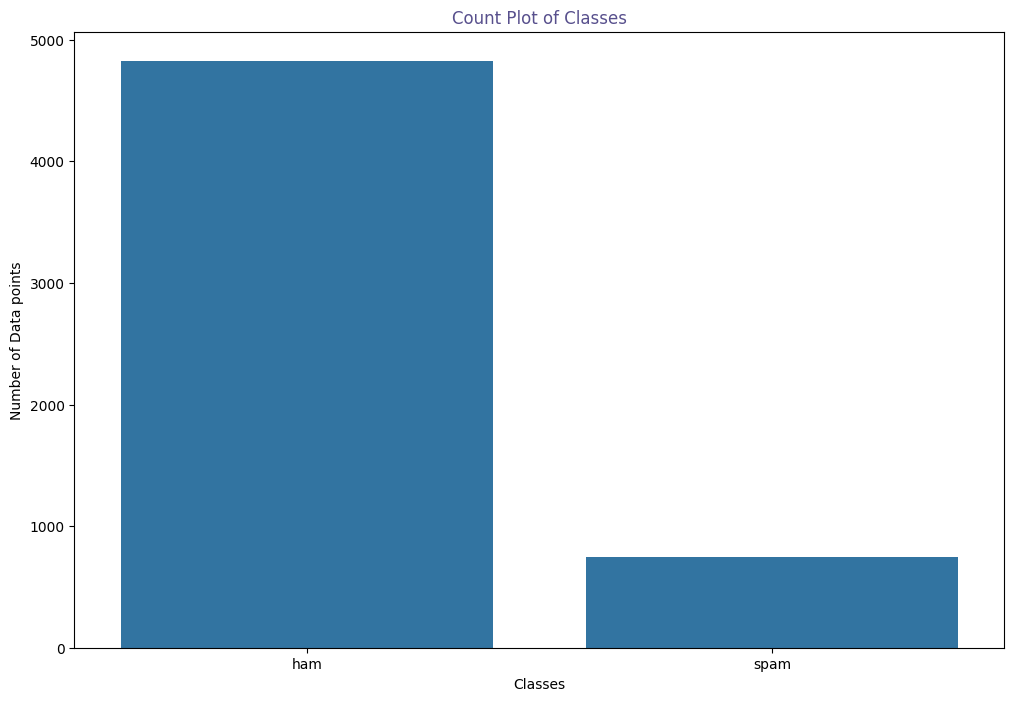

In [5]:
plt.figure(figsize=(12,8))
fg = sns.countplot(x= "class", data=data)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes")
fg.set_ylabel("Number of Data points")


In [6]:
import nltk
data["no_of_chars"] = data["sms"].apply(lambda x: len(x))
data["no_of_words"] = data["sms"].apply(lambda x: len(nltk.word_tokenize(x)))
data["no_of_sentences"] = data["sms"].apply(lambda x: len(nltk.sent_tokenize(x)))

data.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_chars,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
no_of_words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
no_of_sentences,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


<Figure size 1200x800 with 0 Axes>

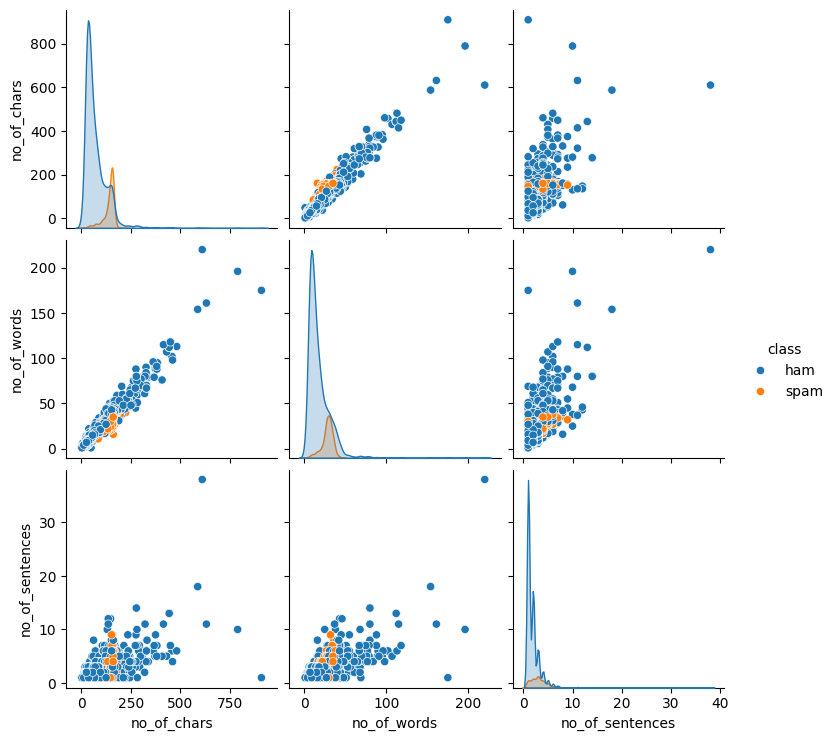

In [7]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="class")
plt.show(fg)

### Outlier Cleaning

In [8]:
Q1 =  data["no_of_chars"].quantile(.25)
Q3 = data["no_of_chars"].quantile(.75) 
IQR = Q3 - Q1
threshold = 1.5
outliers = data.query(f"no_of_chars <= {Q1 - (threshold * IQR)} | no_of_chars >= {Q3 + (threshold * IQR)}")

data_without_outliers = data.drop(outliers.index)


In [9]:
data_without_outliers.shape

(5504, 5)

<Figure size 1200x800 with 0 Axes>

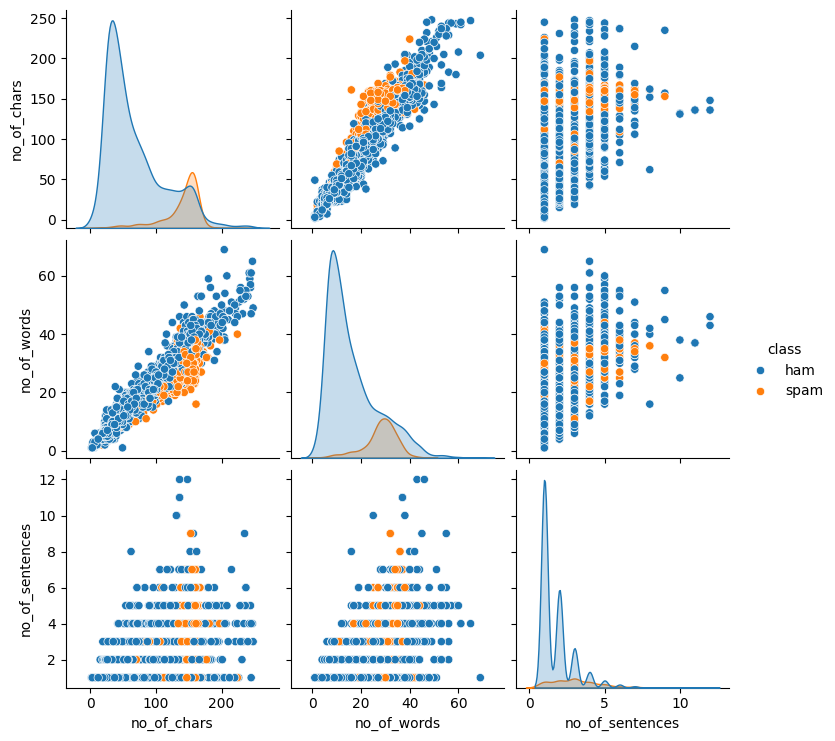

In [10]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data_without_outliers, hue="class")
plt.show(fg)

In [11]:
data_without_outliers.head()

,class,sms,no_of_chars,no_of_words,no_of_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [12]:
data_without_outliers = data_without_outliers.loc[:, "class": "sms"] # Dropping the number columns (They will be calculated after cleaning again!)

In [13]:
data_without_outliers.head()

,class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Preprocessing

### Text Cleaning

In [14]:
nltk.download("stopwords") # Downloading Stopwords
nltk.download("wordnet") # Downloading wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gulse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gulse\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Cleaning the sms texts.

def preprocess_txt(text: str):

    main_words = re.sub('[^a-zA-Z]', ' ', text)                                      # Retain only alphabets
    main_words = (main_words.lower()).split()
    main_words = [w for w in main_words if not w in set(stopwords.words('english'))]  # Remove stopwords
    
    lem = WordNetLemmatizer()
    main_words = [lem.lemmatize(w) for w in main_words if len(w) > 1]                 # Group different forms of the same word
    
    main_words = ' '.join(main_words)
    text = main_words

    return text

In [16]:
data_without_outliers["sms"] = data_without_outliers["sms"].apply(lambda x: preprocess_txt(x))

In [17]:
data_without_outliers["sms"]

0       go jurong point crazy available bugis great wo...
1                                   ok lar joking wif oni
2       free entry wkly comp win fa cup final tkts st ...
3                           dun say early hor already say
4                     nah think go usf life around though
                              ...                        
5567    nd time tried contact pound prize claim easy c...
5568                              going esplanade fr home
5569                                 pity mood suggestion
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: sms, Length: 5504, dtype: object

### Text Vectorizing

In [18]:
num_wordss = 50000
max_len = 250
tokenizer = Tokenizer(num_words = num_wordss, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)


### Label Encoding

In [19]:
le = LabelEncoder()
data_without_outliers["class"] = le.fit_transform(data_without_outliers["class"])

In [20]:
X = tokenizer.texts_to_sequences(data_without_outliers["sms"].values)
X = pad_sequences(X, maxlen=max_len)

y = data_without_outliers["class"].values.reshape(-1, 1)


In [21]:
y

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

## Modeling Training & Evaluation

In [22]:

# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
model = Sequential([
    Embedding(num_wordss, 100,),
    SpatialDropout1D(.2),
    LSTM(100, dropout = .1, recurrent_dropout = .2),
    Dense(27, activation = "softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
history = model.fit(X_train, y_train, epochs=6, batch_size=32,validation_data=(X_test,y_test), callbacks=my_callbacks)

Epoch 1/6


138/138 [==============================] - 28s 184ms/step - loss: 0.6074 - accuracy: 0.8553 - val_loss: 0.4020 - val_accuracy: 0.8629
Epoch 2/6
138/138 [==============================] - 27s 192ms/step - loss: 0.4033 - accuracy: 0.8646 - val_loss: 0.4005 - val_accuracy: 0.8629
Epoch 3/6
138/138 [==============================] - 27s 193ms/step - loss: 0.3999 - accuracy: 0.8646 - val_loss: 0.4005 - val_accuracy: 0.8629
Epoch 4/6
138/138 [==============================] - 27s 192ms/step - loss: 0.4005 - accuracy: 0.8646 - val_loss: 0.4004 - val_accuracy: 0.8629
Epoch 5/6
138/138 [==============================] - 26s 189ms/step - loss: 0.3989 - accuracy: 0.8646 - val_loss: 0.4033 - val_accuracy: 0.8629
Epoch 6/6
138/138 [==============================] - 26s 191ms/step - loss: 0.4020 - accuracy: 0.8646 - val_loss: 0.4047 - val_accuracy: 0.8629


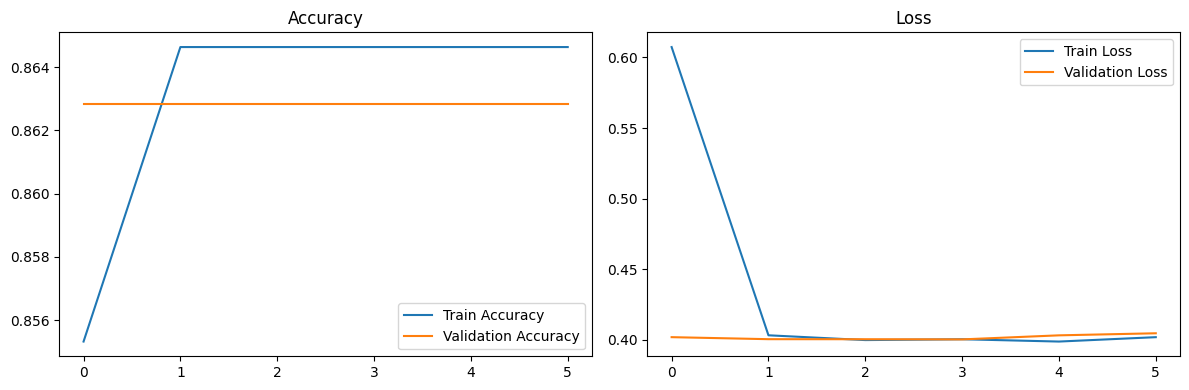

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()


In [26]:
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test,test_predictions))

35/35 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       950
           1       0.00      0.00      0.00       151

    accuracy                           0.86      1101
   macro avg       0.43      0.50      0.46      1101
weighted avg       0.74      0.86      0.80      1101

